# Imports

In [1]:
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import column_or_1d
from sklearn import linear_model
import scipy as sc
from scipy.linalg import block_diag
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import networkx as nx
plt.style.use('ggplot')

In [2]:
# Constants
EARNINGS_STEP = 5000
AGE_STEP = 5
EDUC_STEP = 3

# Question 1

In [3]:
# Read the CSV and put 0.0 values to NaN
lalonde_df = pd.read_csv('lalonde.csv')

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

#### Explanation

We decided to show this by simply computing the average for both group. Also, we thought that showing how much money people in both group make by assigning them to categories (range of money they are making) would help visualize the differences. We chose 5000 as our step size for earnings because it allows to split the people in a meaningful number of categories.

#### Assumptions

We assumed that the people earning 0.0 are unemployed (as it was hinted on Mattermost by a TA).

In [4]:
def plot_distribution(df, attr, step, zero_meaning=None):
    # Add a category column
    attr_df = df.copy()
    attr_df['category'] = attr_df[attr] // step
    
    # Put -1 as a category for zero values if it means something special
    if zero_meaning:
        attr_df.loc[attr_df[attr] == 0, 'category'] = -1

    # Compute the labels
    categories = np.sort(attr_df['category'].unique()) * step
    labels = []
    
    # Add 'zero_meaning' label if any value is at 0.0
    if zero_meaning and (attr_df[attr] == 0).any():
        labels.append(zero_meaning)
    
    for i in range(len(categories)):
        current = categories[i]
        if current < 0:
            continue
            
        if i == len(categories) - 1:
            nextt = '+'
        else:
            nextt = str(int(categories[i+1]))

        labels.append('(%d, %s]' % (current, nextt)) 

    # Show with a barplot the average (again) with the uncertainty
    g = sb.countplot(y='category', hue='treat', data=attr_df)
    g.set(yticklabels=labels)
    
def plot_distribution_binary(df, attr):
    # Show with a barplot the average (again) with the uncertainty
    g = sb.countplot(y=attr, hue='treat', data=df)

In [5]:
# Compute the mean in earnings (1978) for both treatments
print("Mean of earnings (full dataset):")
print("Control group:", np.mean(lalonde_df[lalonde_df['treat'] == 0]['re78']))
print("Treated group:", np.mean(lalonde_df[lalonde_df['treat'] == 1]['re78']))

Mean of earnings (full dataset):
Control group: 6984.169742307697
Treated group: 6349.143530270269


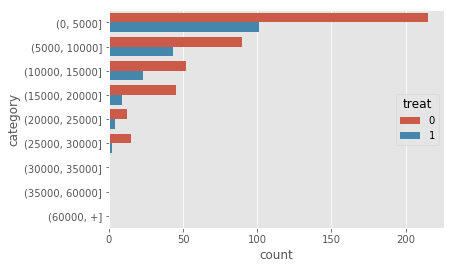

In [6]:
# Show the distribution of earnings
plot_distribution(lalonde_df, 're78', EARNINGS_STEP)

#### Result
A naive "researcher" would say that the control group people earn more in average, thus the treatment didn't do anything (and it would even be better not to do it).

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

#### Explanation

To compare both distributions, we use the same kind of plot we used earlier but for all features. This allows us to see the inequalities (discussed in the results).

#### Assumptions

We assumed (again) that the people earning 0.0 are unemployed (as it was hinted on Mattermost by a TA).

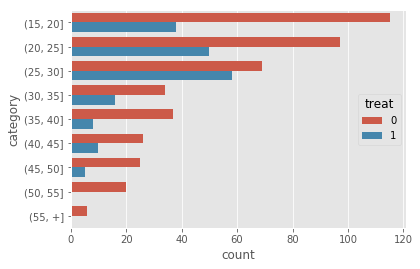

In [7]:
plot_distribution(lalonde_df, 'age', AGE_STEP)

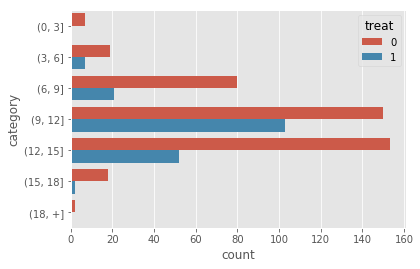

In [8]:
plot_distribution(lalonde_df, 'educ', EDUC_STEP)

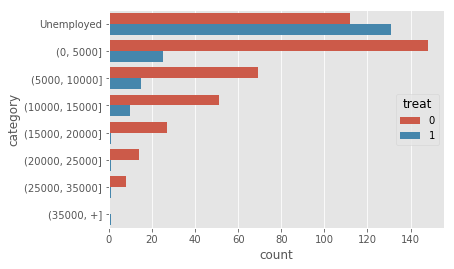

In [9]:
plot_distribution(lalonde_df, 're74', EARNINGS_STEP, 'Unemployed')

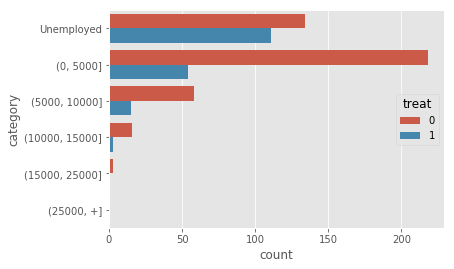

In [10]:
plot_distribution(lalonde_df, 're75', EARNINGS_STEP, 'Unemployed')

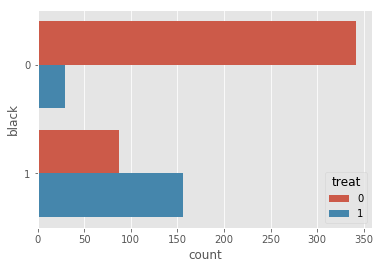

In [11]:
plot_distribution_binary(lalonde_df, 'black')

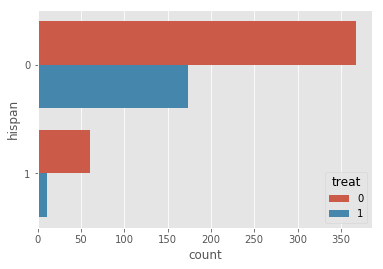

In [12]:
plot_distribution_binary(lalonde_df, 'hispan')

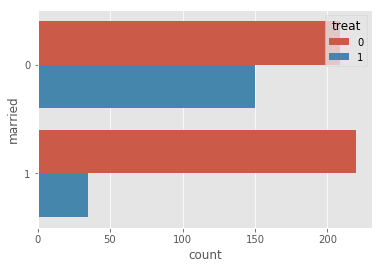

In [13]:
plot_distribution_binary(lalonde_df, 'married')

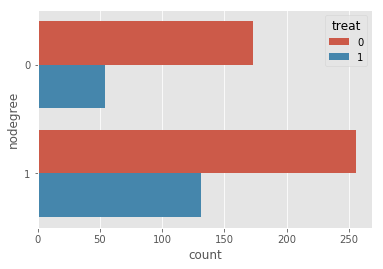

In [14]:
plot_distribution_binary(lalonde_df, 'nodegree')

#### Result
The dataset is unbalanced because we can see that the people in the control group and in the treated group are not similar, we can see that the distributions are quite different (e.g. lots of "non-black people" in the control group compared to the treated group). This means that the conclusions made by the "naive" researcher are most likely wrong because it is not based on a balanced dataset.

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

#### Explanation

We can compute the weights of the different features by using logistic regression, with X being all features except 'id', 'treat' and 're78' and y being 'treat'. Once we have that, we can compute an associated score (the expected 'treat', as a real number), standardize it and then derive the probability (for every point) of being treated (i.e. the propensity score); to do so, we take the sigmoid of the score, which is smoothly mapping the score into the [0, 1] range.


In [15]:
# Compute 'w' in order to get the propensity scores
logistic = linear_model.LogisticRegression()
X = lalonde_df.drop(['id', 'treat', 're78'], axis=1)
y = lalonde_df['treat']
model = logistic.fit(X, y)
w = logistic.coef_

print("Weights of features:")
print(X.columns.values)
print(w)

# Get the probability of being treated
prob = model.predict_proba(X)[:, 1]

# DataFrame with propensity score
propensity_df = lalonde_df.copy()
propensity_df['prop_score'] = prob

# Showing some from the treated group and some from the control group
pd.concat([propensity_df.head(5), propensity_df.tail(5)])

Weights of features:
['age' 'educ' 'black' 'hispan' 'married' 'nodegree' 're74' 're75']
[[ -6.79420318e-03  -6.60222904e-02   2.58431259e+00  -4.06653854e-02
   -8.41479118e-01  -3.60730744e-01  -7.54171135e-05   5.75922263e-05]]


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286
609,PSID425,0,18,11,0,0,0,1,0.0,0.0,10150.5000,0.136895
610,PSID426,0,24,1,0,1,1,1,0.0,0.0,19464.6100,0.108708
611,PSID427,0,21,18,0,0,0,0,0.0,0.0,0.0000,0.123129
612,PSID428,0,32,5,1,0,1,1,0.0,0.0,187.6713,0.550460
613,PSID429,0,16,9,0,0,0,1,0.0,0.0,1495.4590,0.155030


#### Results

From the computed weights, we can derive how "important" a feature is in order to tell if the person is in the treated group or not. For example, the most important feature seems to be the feature 'black'; indeed, it seems that it is way more likely that the person is in the treated group if this person is black.

Also, if you look at the propensity score in the DataFrame, you can see that indeed, in general, a bigger score means most likely that the person is in the treated group.

#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?



#### Explanation
Using the library networkx we create a bipartite graphe $G=(V,E)$ where $V$ is partitioned into two subset $A$,$B$ and each node in $A$ is a treated person and each node in $B$ is a non-treated person. The set of edges $E$ is constructed sucht that $e=(a,b) \in E$, $\forall a \in A$, $\forall b \in B$. We also asign a weight to each edges such that $w(e) =abs(prop\_score_b - prop\_score_a)$.

In [16]:
idx_treated = np.where(propensity_df['treat'] == 1)[0]
idx_non_treated = np.where(propensity_df['treat'] == 0)[0]

# Create the graph by adding all indices as nodes
G = nx.Graph()
for idx in propensity_df.index:
    G.add_node(idx)
    
# Add edges between the nodes with the weight being 1 minus the diff in propensity score
# (since there is no 'min_weight_matching' function)
for idx_t in idx_treated:
    for idx_non_t in idx_non_treated:
        w = 1 - (np.abs(propensity_df['prop_score'].iloc[idx_t] - propensity_df['prop_score'].iloc[idx_non_t]))
        G.add_edge(idx_t, idx_non_t, weight=w)   
        
# All matchings (as a dictionary)
matchings = nx.max_weight_matching(G)

In [17]:
# Now we want to remove the similar pairs (e.g. (x, y) and (y, x))
clean_matchings = {}
for k,v in matchings.items():
    if not v in clean_matchings:
        clean_matchings[k] = v

# Create a list of pairs (matchings)
clean_matchings = list(clean_matchings.items())

In [18]:
# Get the indices for control group and treated group
idx_treated_matched = [x[0] if x[0] in idx_treated else x[1] for x in clean_matchings]
idx_non_treated_matched = [x[0] if x[0] in idx_non_treated else x[1] for x in clean_matchings]

# Create new DF based on those indices
treated_df = propensity_df.loc[idx_treated_matched]
non_treated_df = propensity_df.loc[idx_non_treated_matched]
matched_df = pd.concat([treated_df, non_treated_df])

Now that we have a new DF with only the matchings, let's see the distribution of the different features again.

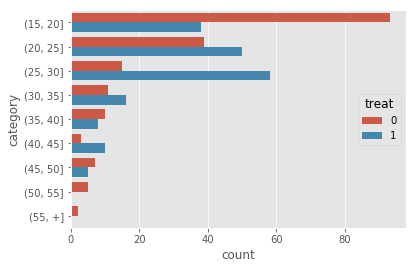

In [19]:
plot_distribution(matched_df, 'age', AGE_STEP)

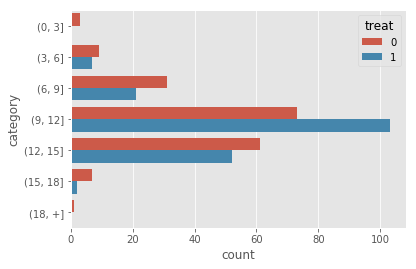

In [20]:
plot_distribution(matched_df, 'educ', EDUC_STEP)

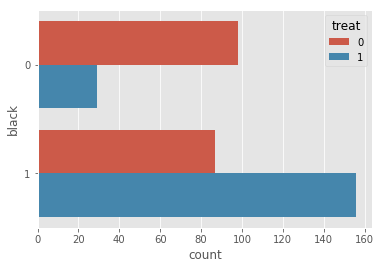

In [21]:
plot_distribution_binary(matched_df, 'black')

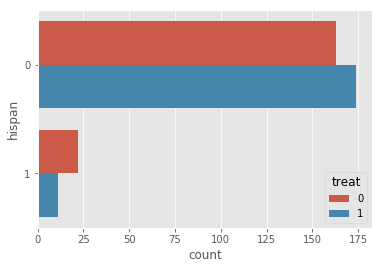

In [22]:
plot_distribution_binary(matched_df, 'hispan')

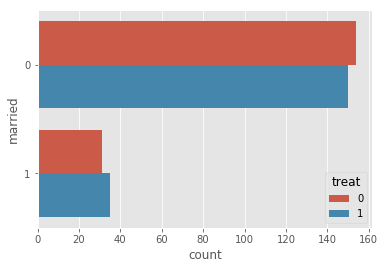

In [23]:
plot_distribution_binary(matched_df, 'married')

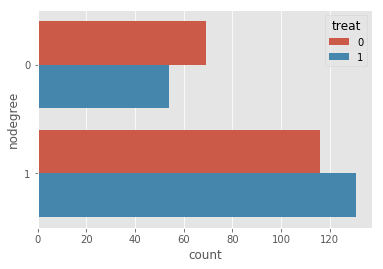

In [24]:
plot_distribution_binary(matched_df, 'nodegree')

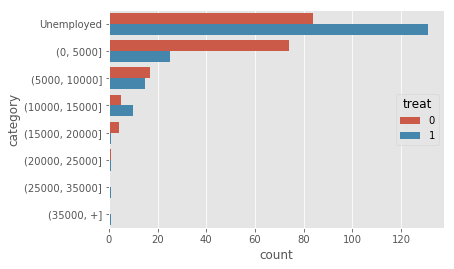

In [25]:
plot_distribution(matched_df, 're74', EARNINGS_STEP, 'Unemployed')

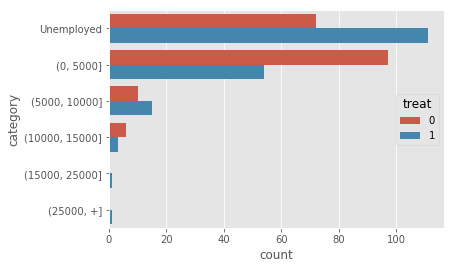

In [26]:
plot_distribution(matched_df, 're75', EARNINGS_STEP, 'Unemployed')

#### Results
Most of the binary features are balanced except for the black feature where most of the people that have the black feature have followed the treatment. This can still biaise the analysis since there is not enough people whith the black feature that haven't followed the treatment to match treated people with the black feature.

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


#### Explanation

As you can see on the plot, the 'black' feature is still unbalanced compared to the others. So when creating the edges in the graph, we should force that both nodes correspond to a person with the same 'black' feature. This way, the set of edges is constructed such that $e=(a,b) \in E$, $a \in A, b \in B$ and $black_a=black_b$.

In [27]:
idx_treated = np.where(propensity_df['treat'] == 1)[0]
idx_non_treated = np.where(propensity_df['treat'] == 0)[0]

# Create the graph by adding all indices as nodes
G = nx.Graph()
for idx in propensity_df.index:
    G.add_node(idx)
    
# Add edges between the nodes with the weight being 1 minus the diff in propensity score
# (since there is no 'min_weight_matching' function)
for idx_t in idx_treated:
    for idx_non_t in idx_non_treated:
        # Make sure we can only match those with the same 'black' feature
        if propensity_df['black'].iloc[idx_t] == propensity_df['black'].iloc[idx_non_t]:
            w = 1 - (np.abs(propensity_df['prop_score'].iloc[idx_t] - propensity_df['prop_score'].iloc[idx_non_t]))
            G.add_edge(idx_t, idx_non_t, weight=w)   
        
# All matchings (as a dictionary)
matchings = nx.max_weight_matching(G)

In [28]:
# Now we want to remove the similar pairs (e.g. (x, y) and (y, x))
clean_matchings = {}
for k,v in matchings.items():
    if not v in clean_matchings:
        clean_matchings[k] = v

# Create a list of pairs (matchings)
clean_matchings = list(clean_matchings.items())

In [29]:
# Get the indices for control group and treated group
idx_treated_matched = [x[0] if x[0] in idx_treated else x[1] for x in clean_matchings]
idx_non_treated_matched = [x[0] if x[0] in idx_non_treated else x[1] for x in clean_matchings]

# Create new DF based on those indices
treated_df = propensity_df.loc[idx_treated_matched]
non_treated_df = propensity_df.loc[idx_non_treated_matched]
matched_df = pd.concat([treated_df, non_treated_df])

Let's take a look at the distributions now.

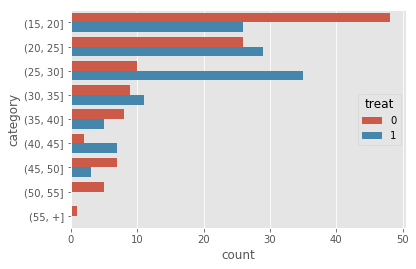

In [30]:
plot_distribution(matched_df, 'age', AGE_STEP)

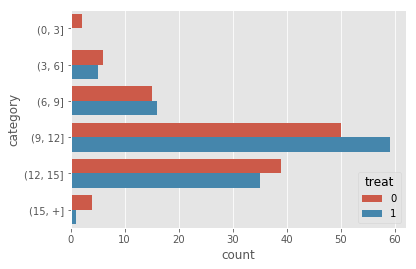

In [31]:
plot_distribution(matched_df, 'educ', EDUC_STEP)

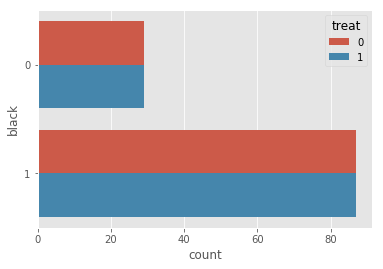

In [32]:
plot_distribution_binary(matched_df, 'black')

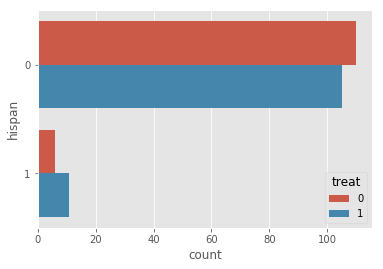

In [33]:
plot_distribution_binary(matched_df, 'hispan')

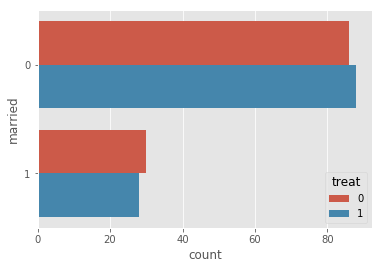

In [34]:
plot_distribution_binary(matched_df, 'married')

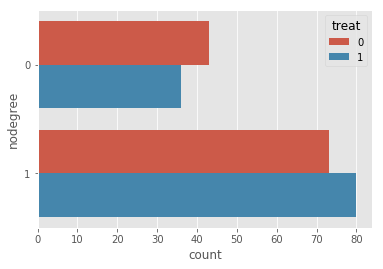

In [35]:
plot_distribution_binary(matched_df, 'nodegree')

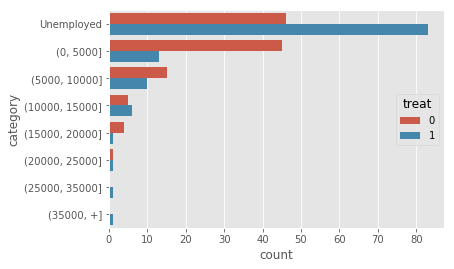

In [36]:
plot_distribution(matched_df, 're74', EARNINGS_STEP, 'Unemployed')

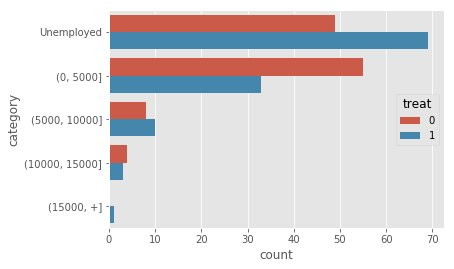

In [37]:
plot_distribution(matched_df, 're75', EARNINGS_STEP, 'Unemployed')

#### Results

We see now that for all the binary features the set is balanced and that the black feature has exactly the same number of treated as non-treated with or without the black feature.

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?


#### Explanation

We will do as in part 1 but this time with the balanced group. We will first look at the mean of salary in 78 for both group, then we will look at the distribution.

In [38]:
print("Mean of earnings (balanced dataset):")
print("Control group:", np.mean(non_treated_df['re78']))
print("Treated group:", np.mean(treated_df['re78']))

Mean of earnings (balanced dataset):
Control group: 5255.063147844827
Treated group: 7070.7105103448275


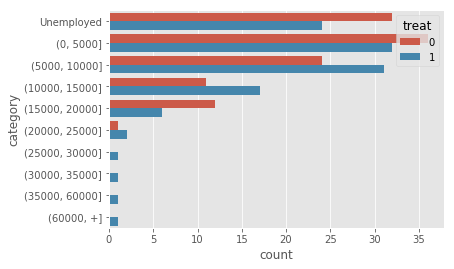

In [39]:
plot_distribution(matched_df, 're78', EARNINGS_STEP, 'Unemployed')

#### Results

Looking now at the average salary in each group we see clearly a difference between treated and non-treated person. We also show the distrubution of salary. From it we see that for most of the category the peron treated have a higher salaray.

# Question 2

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

## Solution

### Explanation and assumptions

#### Explanation

In order to create a Random Forest to classify the news articles, we start by downloading all the data.

We then use the `TfidfVectorizer` to turn the data into vectors in order to be able to insert it in our random forest.

Then, we split the data into 2 sets, a training set and a test set. The test set is 10% of the size of the entire dataset. 

After that, we use grid search and cross-validation to fine tune our model and select the best parameters for max_depth and n_estimators (which is the depth of the trees and the number of trees in the random forest, respectivel)

Finally, when we obtain a good-enough accuracy in our validation phase, we assess the model and test the accuracy on the test set. We also plot a confusion matrix where we can see the accuracy for each category

#### Assumptions

We assumed that the training data was well balanced (and verified that it was) before creating the test and training sets. It the data was not balanced, we could have used a weighted or stratified sampling.

### Data retrieving

We directly load the data using sklearn

In [40]:
newsgroups = fetch_20newsgroups(subset='all')

We check that the data is well balanced

In [41]:
for i in range(19):
    print(np.count_nonzero(newsgroups.target == i))

799
973
985
982
963
988
975
990
996
994
999
991
984
990
987
997
910
940
775


And we convert the text to vectors taking care of setting a *max_features* parameter in order to have the same number of features in the train and test set.

In [42]:
vectorizer = TfidfVectorizer()
newsgroups.vectors = vectorizer.fit_transform(newsgroups.data)
print('Set shape:', newsgroups.vectors.shape)

Set shape: (18846, 173762)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(newsgroups.vectors, newsgroups.target, test_size=0.1)

In [44]:
X_train.shape

(16961, 173762)

### Random forest

In [45]:
SCORING = ['accuracy', 'neg_mean_squared_error']

In [46]:
def runCV(clf, X_train, y_train, k):
    scores = cross_validate(clf, X_train, y_train, cv=k, scoring=SCORING, return_train_score=False)
    print_scores(scores)
    return scores
        
def print_scores(scores):
    print('Scores')
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
    print("RMSE: %0.2f (+/- %0.2f)" % (np.sqrt(-scores['test_neg_mean_squared_error']).mean(), scores['test_neg_mean_squared_error'].std() * 2))

With **k-fold cross validation** and **grid_search**, we found that good parameters are:

* n_estimators = 400
* max_depth = 100

Further fine-tuning can be done but we estimated that those parameters were enough considering the long running-time involved in finding the best parameters.

In [47]:
def fine_tuning(depths, estimators):
    best_depth = 0;
    best_estimators = 0;
    best_acc = 0;

    for max_depth in depths:
        for n_estimators in estimators:
            clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=42,
                n_jobs=-1
            )
            scores = runCV(clf, X_train, newsgroups_train.target, 7)
            acc = scores['test_accuracy'].mean()

            if acc > best_acc:
                best_depth = max_depth
                best_estimators = n_estimators
                best_acc = acc
                
    print('Best parameters are (accuracy of', best_acc, '):')
    print('Depth:', best_depth, 'n_estimators:', best_estimators)
    
    return best_depth, best_estimators

In [ ]:
fine_tuning([30, 50, 70, 90, 100], [50, 150, 200, 300, 350, 400])

In [48]:
max_depth = 100
n_estimators = 400

In [49]:
clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Model assessment

In [50]:
pred = clf.predict(X_test)
acc = accuracy_score(y_test, pred)
acc

0.86259946949602118

We obtain an accuracy of 85%, which is pretty good so we stop the research here

### Confusion matrix

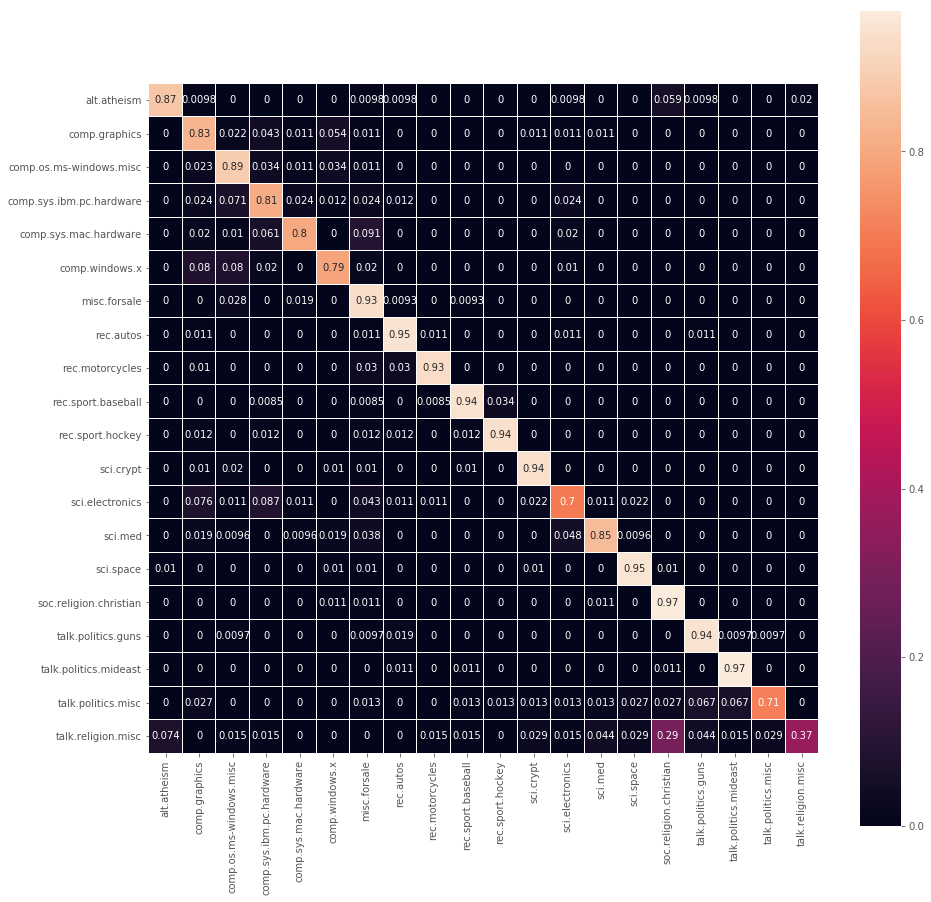

In [51]:
cm = confusion_matrix(y_test, pred)
cm = pd.DataFrame(cm, index=newsgroups.target_names, columns=newsgroups.target_names)
cm = cm.div(cm.sum(axis=1), axis=0)
plt.figure(figsize=(15, 15))
sb.heatmap(cm, square=True, annot=True, linewidths=0.1)
plt.show()

We can see that our model is accurate most of the time, some categories like talk_religion_misc are more difficult to classify than caregories like sci_space or sport_hockey. This is surely due to highly specific words 

### Analyzing feature importances

In [52]:
sorted_features = np.flip(np.sort(clf.feature_importances_), axis=0)
sorted_features

array([ 0.0048442 ,  0.00467572,  0.00434008, ...,  0.        ,
        0.        ,  0.        ])

In [53]:
np.count_nonzero(sorted_features == 0)

89543

We can see that some features have an importance of 0. This means that those features are not used at all to classify the articles. Those features correspond to words that are common in every article. Like "point", "comma", "the", etc.

The number of features that have a weight of 0 is really high. A lot of features do not have any influence in the decision of the category.

After seeing this, we can decide to use a dimensionality reduction method (like PCA or truncatedSVD) to delete unnecessary features and accelerate the process.